In [1]:
import warnings
warnings.filterwarnings("ignore")


import requests

import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 

#from wrangle import get_crypto_price

import wrangle as w

In [2]:
btc = w.get_crypto_price('btc', '2018-01-01', '2022-12-12')

btc = w.clean_data(btc)

In [3]:
# human splitting by year
train = btc[:'2020']
validate = btc['2021']
test = btc['2022']

col = 'btc_volume'

In [4]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [5]:
# plot and evaluate
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [6]:
# Create the empty dataframe
#eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [7]:
def test_evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [8]:
def plot_and_eval_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, color="red")
    rmse = test_evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.title(target_var)
    plt.legend()
    plt.show()

In [9]:
def get_btc_last_observed(train, validate, volume, yhat_df):#, eval_df):
    
    volume = train['btc_volume'][-1:][0]

    yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                           index = validate.index)
    #plot_and_eval(col)
    
    #eval_df = append_eval_df(model_type = 'last_observed_value', 
    #                         target_var = col)

    return volume, yhat_df#, eval_df, 

In [10]:
def get_btc_simple_average(train, validate, volume, yhat_df):#, eval_df):
    
    # getting the average of btc_volume in train
    volume = round(train['btc_volume'].mean(), 2)


    yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                           index = validate.index)

    #eval_df = append_eval_df(model_type='simple_average', 
    #                         target_var = col)
    
    return volume, yhat_df#, eval_df,

In [11]:
def get_btc_30d_average(train, validate, volume, yhat_df):#, eval_df):
    
    period = 30
    volume = round(train['btc_volume'].rolling(period).mean().iloc[-1], 2)

    yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                           index = validate.index)

    #eval_df = append_eval_df(model_type='simple_average', 
    #                         target_var = col)
    
    return volume, yhat_df#, eval_df,

In [12]:
#def get_btc_moving_average(train, validate, volume, yhat_df):
#     try out several periods
#    periods = [1,7,14,21,28,120]
#
#   for p in periods:
#        volume = round(train['btc_volume'].rolling(p).mean().iloc[-1], 2)
#
#
#        yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
#                           index = validate.index)

#        model_type = str(p) + 'd moving average'
#        eval_df = append_eval_df(model_type = model_type, 
#                                 target_var = col)
#    return volume, yhat_df, eval_df

# Testing ground

In [36]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# Initialize volume, yhat_df, and period for modeling
volume = 0 #train['btc_volume'][-1:][0]

yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

period = 0

## Last Observed

In [37]:
volume, yhat_df = get_btc_last_observed(train, validate, volume, yhat_df)

In [38]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36067.0


In [17]:
#yhat_df

btc_volume -- RMSE: 36067


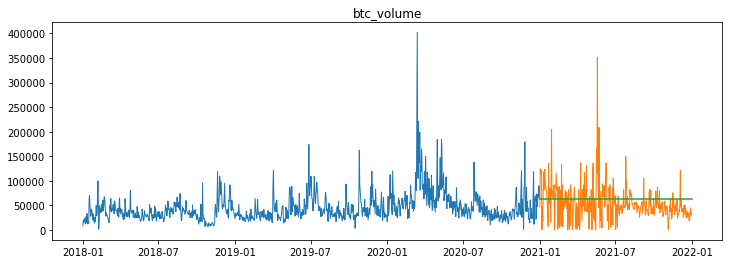

In [18]:
plot_and_eval(col)

## Simple Average

In [19]:
volume, yhat_df = get_btc_simple_average(train, validate, volume, yhat_df)

In [20]:
#eval_df

In [21]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [22]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36067.0
1,simple_average,btc_volume,36780.0


btc_volume -- RMSE: 36780


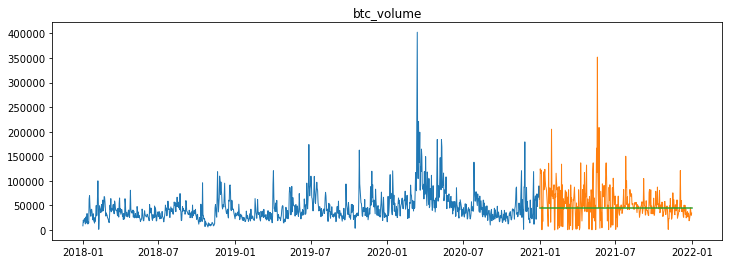

In [23]:
plot_and_eval(col)

## Moving Average

In [24]:
volume, yhat_df = get_btc_30d_average(train, validate, volume, yhat_df)

In [25]:
eval_df = append_eval_df(model_type='30d_moving_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0


btc_volume -- RMSE: 35674


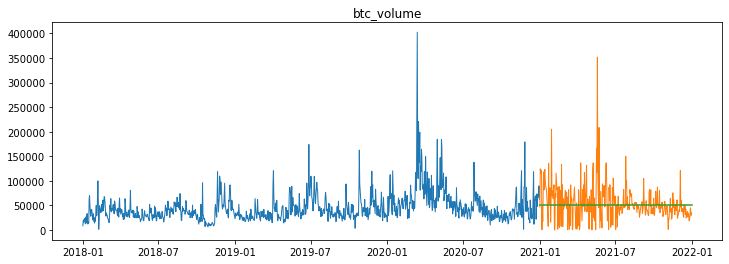

In [26]:
plot_and_eval(col)

## Moving AVG++++

In [27]:
periods = [7,14,21,28,120]

In [28]:
for p in periods:
        volume = round(train['btc_volume'].rolling(p).mean().iloc[-1], 2)


        yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                           index = validate.index)

        model_type = str(p) + 'd moving average'
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [29]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,1d moving average,btc_volume,36067.0
4,7d moving average,btc_volume,38030.0
5,14d moving average,btc_volume,35616.0
6,21d moving average,btc_volume,35361.0
7,28d moving average,btc_volume,35676.0
8,120d moving average,btc_volume,37989.0


## Previous Cycle

In [30]:
def get_btc_previous_cycle(train, validate):
    
    yhat_df = train['2020'] + train.diff(365).mean()
    yhat_df.index = validate.index
    
    return yhat_df

In [31]:
yhat_df = get_btc_previous_cycle(train, validate)

btc_volume -- RMSE: 54671


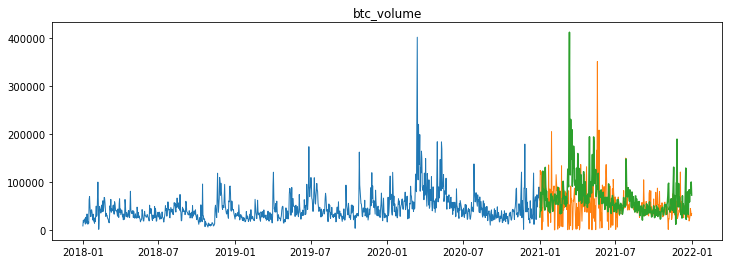

In [32]:
plot_and_eval(target_var = col)

eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [33]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,1d moving average,btc_volume,36067.0
4,7d moving average,btc_volume,38030.0
5,14d moving average,btc_volume,35616.0
6,21d moving average,btc_volume,35361.0
7,28d moving average,btc_volume,35676.0
8,120d moving average,btc_volume,37989.0
9,previous year,btc_volume,54671.0


# Test

In [34]:
period = 21
volume = round(train['btc_volume'].rolling(period).mean().iloc[-1], 2)


yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = test.index)

btc_volume -- RMSE: 68477


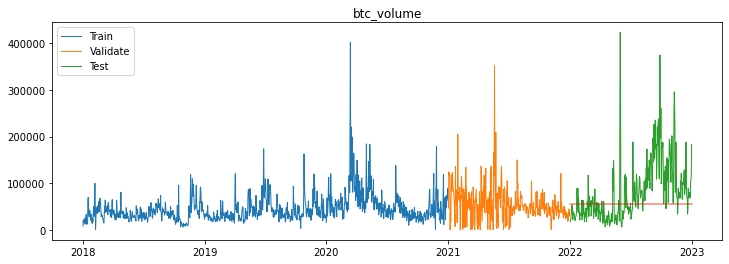

In [35]:
plot_and_eval_test(col)